In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

In [2]:
%matplotlib inline

import os
import h5py
import json
import numpy as np
import matplotlib.pyplot as plt
# importing rastermap
# (this will be slow the first time since it is compiling the numba functions)
from rastermap import Rastermap, utils
from scipy.stats import zscore

from utils.neurosuite import get_unit_names_sorted


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Users/andrey/anaconda3/envs/pyUMAP/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/andrey/anaconda3/envs/pyUMAP/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Users/andrey/anaconda3/envs/pyUMAP/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/andrey/anaconda3/envs/pyUMAP/lib/python3.10/site-packages/traitlets/config/application.py", lin

AttributeError: _ARRAY_API not found

ImportError: numpy.core.multiarray failed to import

In [1]:
source  = '/Users/andrey/nevermind/AG_Pecka/data/processed/'
session = '013608_ppcSIT_2025-01-16_09-49-21'
#session = '008229_hippoSIT_2022-05-16_20-36-44'

animal      = session.split('_')[0]
meta_file   = os.path.join(source, animal, session, 'meta.h5')
units_file  = os.path.join(source, animal, session, 'units.h5')

NameError: name 'os' is not defined

In [63]:
# reading events and spiking data
with h5py.File(meta_file, 'r') as f:
    tl = np.array(f['processed']['timeline'])
    sound_events = np.array(f['processed']['sound_events'])
    cfg = json.loads(f['processed'].attrs['parameters'])
    tgt_mx = np.array(f['processed']['target_matrix'])

spike_times = {}
with h5py.File(units_file, 'r') as f:
    unit_names = get_unit_names_sorted([name for name in f])
    for unit_name in f:
        spike_times[unit_name] = np.array(f[unit_name]['spike_times'])

In [64]:
bin_size = 0.2

t_bins = np.arange(0, tl[-1][0], bin_size)
unit_mx = np.zeros([len(spike_times), len(t_bins)-1])
for i, (unit_name, s_times) in enumerate(spike_times.items()):
    unit_mx[i], _ = np.histogram(s_times, bins=t_bins)

unit_mx = zscore(unit_mx, axis=1)

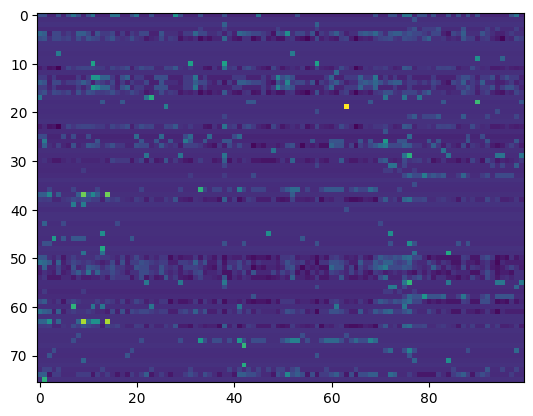

In [65]:
plt.imshow(unit_mx[:, 0:100])

In [66]:
model = Rastermap(n_clusters=None, # None turns off clustering and sorts single neurons 
                  n_PCs=64, # use fewer PCs than neurons
                  locality=0.1, # some locality in sorting (this is a value from 0-1)
                  time_lag_window=15, # use future timepoints to compute correlation
                  grid_upsample=0, # 0 turns off upsampling since we're using single neurons
                ).fit(unit_mx)

2025-01-16 22:35:48,610 [INFO] normalizing data across axis=1
2025-01-16 22:35:48,612 [INFO] projecting out mean along axis=0
2025-01-16 22:35:48,615 [INFO] data normalized, 0.00sec
2025-01-16 22:35:48,615 [INFO] sorting activity: 76 valid samples by 11999 timepoints
2025-01-16 22:35:48,671 [INFO] n_PCs = 64 computed, 0.06sec
2025-01-16 22:35:48,672 [INFO] skipping clustering, n_clusters is None
2025-01-16 22:35:51,558 [INFO] clusters sorted, time 2.95sec
2025-01-16 22:35:51,566 [INFO] rastermap complete, time 2.96sec


In [67]:
y = model.embedding # neurons x 1
isort = model.isort

In [68]:
tgt_mx

array([[    61,     84,   1544,   2119,      1],
       [   217,    240,   5444,   6019,      1],
       [   389,    412,   9744,  10319,      1],
       [   597,    620,  14944,  15519,      1],
       [   734,    757,  18369,  18944,      1],
       [   854,    854,  21369,  21369,      0],
       [  1057,   1080,  26445,  27020,      1],
       [  1215,   1238,  30395,  30970,      1],
       [  1392,   1394,  34820,  34870,      0],
       [  1396,   1419,  34920,  35495,      1],
       [  1518,   1541,  37970,  38545,      1],
       [  1863,   1886,  46595,  47170,      1],
       [  1973,   1997,  49345,  49945,      1],
       [  2249,   2272,  56245,  56820,      1],
       [  2454,   2477,  61370,  61945,      1],
       [  2562,   2586,  64070,  64670,      1],
       [  2704,   2719,  67620,  67995,      0],
       [  2723,   2727,  68095,  68195,      0],
       [  2730,   2734,  68270,  68370,      0],
       [  2830,   2853,  70770,  71345,      1],
       [  3004,   30

Text(0, 0.5, 'superneurons')

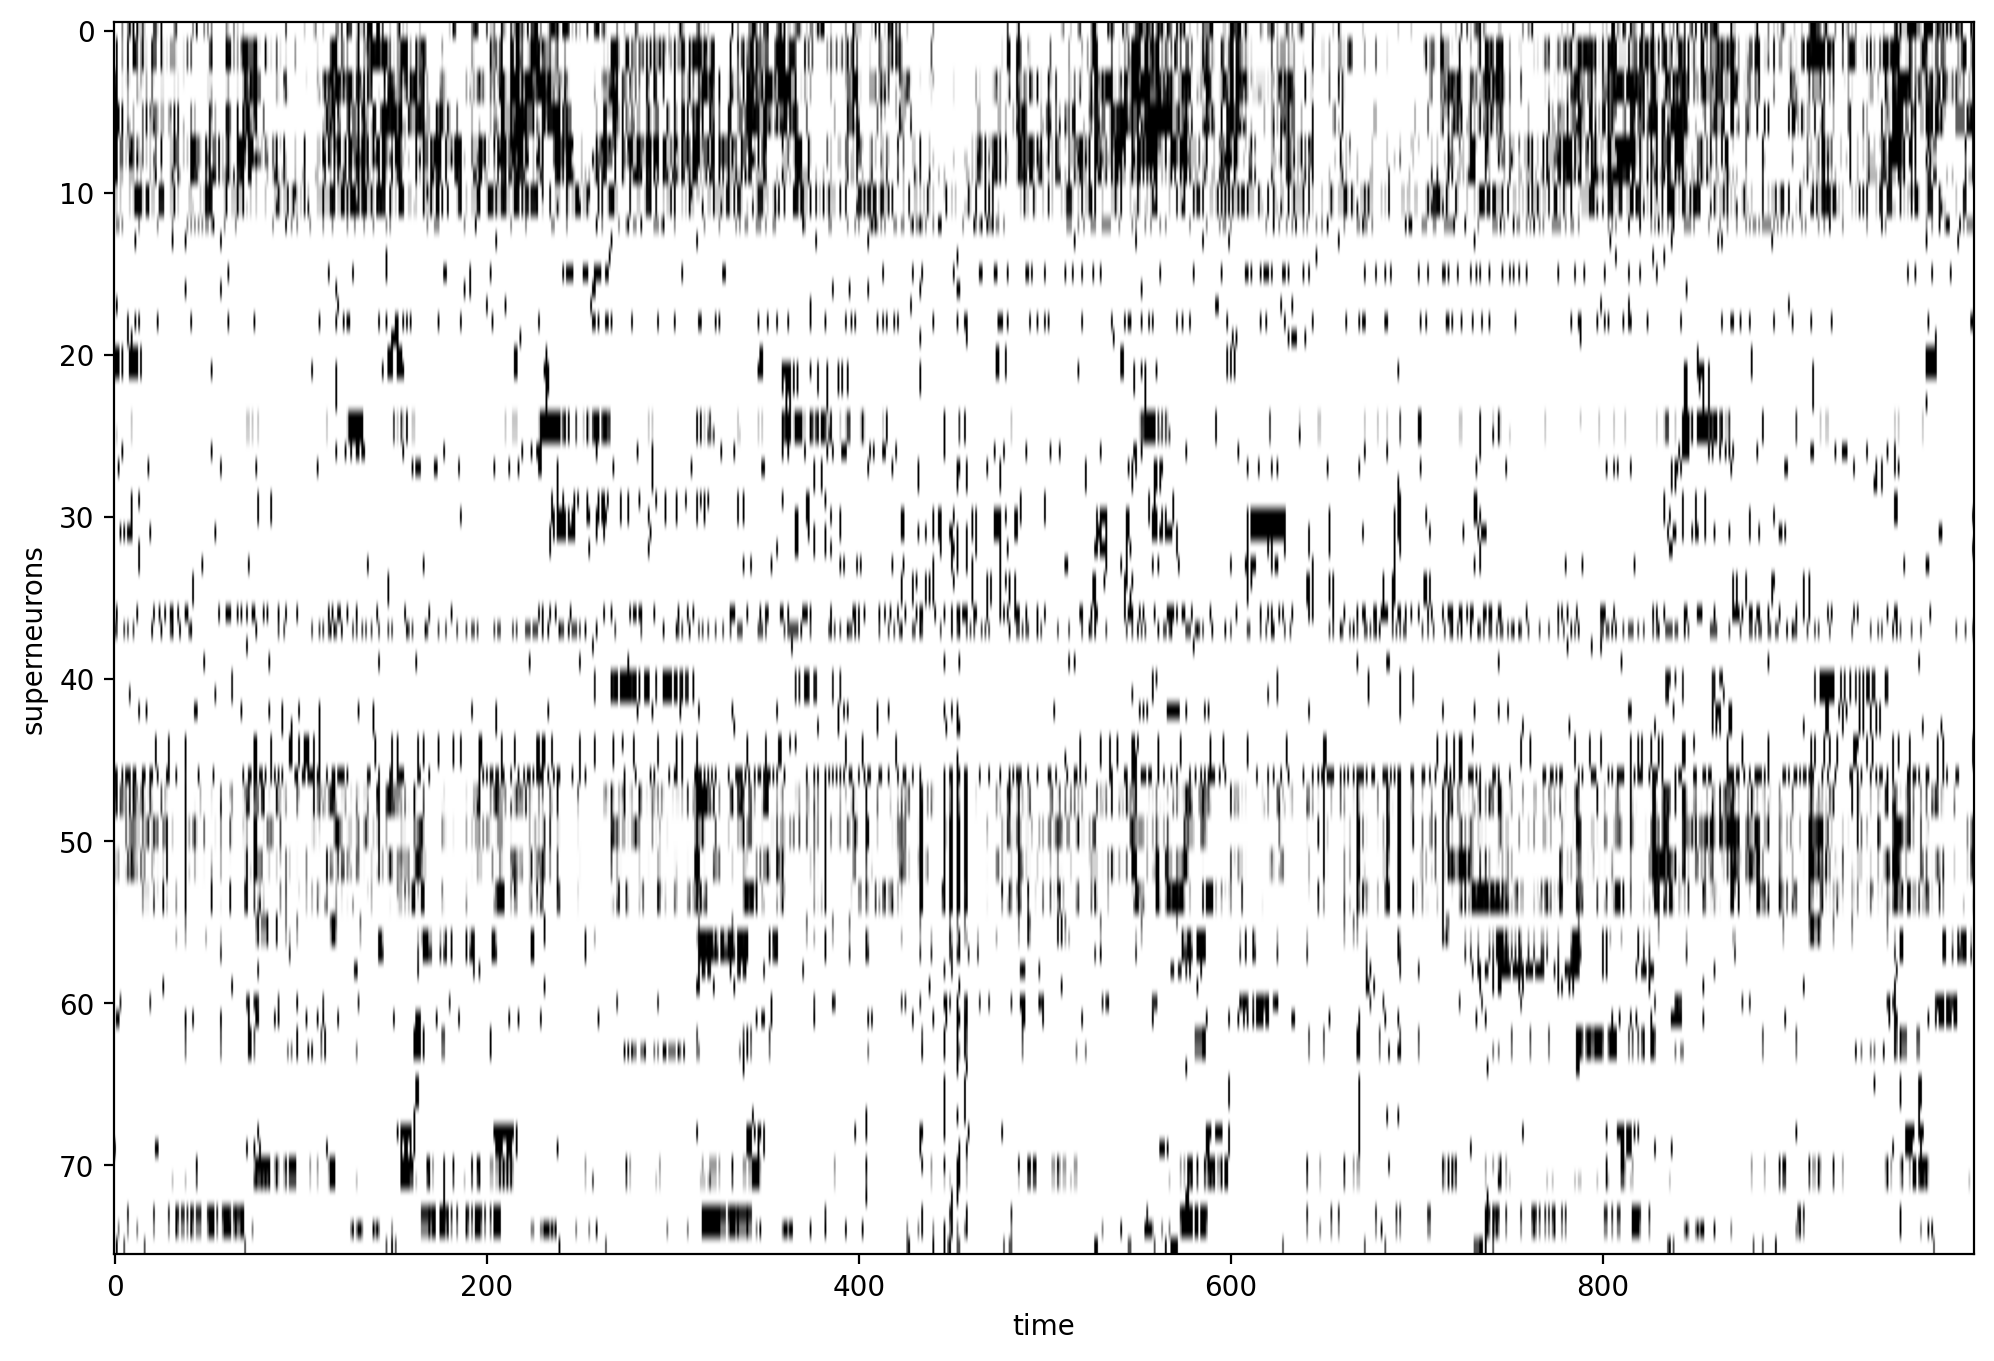

In [75]:
# timepoints to visualize
xmin = 0
xmax = xmin + 1000

fig = plt.figure(figsize=(12,8), dpi=200)

ax = fig.add_subplot(111)
ax.imshow(unit_mx[isort, xmin:xmax], cmap="gray_r", vmin=0, vmax=1.2, aspect="auto")
#for tgt in tgt_mx[tgt_mx[:, 4] == 1]:
#    if tgt[2] > xmin and tgt[2] < xmax:
#        ax.axvline(tgt[2], color='green')

ax.set_xlabel("time")
ax.set_ylabel("superneurons")